# Los bloques de construcción matemáticos del aprendizaje profundo (parte II)

En este cuaderno vamos a ver:

* Un ejemplo de red neuronal
* El concepto de tensor y operaciones con tensores
* Cómo las redes neuronales aprenden a través del algoritmo de retropropagación y el descenso por gradiente

**EJERCICIOS: Durante este cuaderno de prácticas verás ejercicios y preguntas marcadas con ❓❓❓. Puedes contestar añadiendo nuevos bloques de texto (breve) y/o código a continuación de la pregunta.**



Este cuaderno está basado en los cuadernos del libro [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

> This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.
> **If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**
> This notebook was generated for TensorFlow 2.6.

### Reimplementando nuestro ejemplo desde cero en TensorFlow

Una forma de poner a prueba lo que se ha aprendido sobre algo es implementarlo "desde cero". Y esto vamos a hacer con una red neuronal. Obviamente no vamos a reimplementar operadores de matrices o algoritmos de optimización, pero si los componentes básicos de una red.


#### Clase Dense

La clase `Dense` implementa la siguiente transformación de los datos de entrada donde `W` y `b` son los datos del modelo:

```
output = activation(dot(W, input) + b)
```

Donde la función de actividad suele ser `relu` para capas ocultas o `softmax` en la última capa.

**Nota de orientación a objetos en Python**:
* El método `__init__` es el constructor de la clase y se llama al crear una instancia de la clase para asignar valores por defecto a los atributos de la clase.
* El método `__call__` es el método que se lanza cuando se llama a la instancia de la clase como si fuera una función.



In [1]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        # Creamos una matriz inicializada aleatoriamente de forma (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        # Vector inicializado con ceros de forma (output_size,)
        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs): # forward pass
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

**Nota de orientación a objetos en Python**: `@property` se utiliza para definir un método `weights` que se comporta como un atributo/propiedad lo que significa que puede ser accedido como objeto sin la necesidad de llamarlo como un método (`objeto.weights()`). La función weights devuelve una lista que contiene los pesos (W) y los sesgos (b) de la capa. Esto permite que sean accesibles desde fuera de la clase pero al mismo tiempo que no se puedan modificar directamente fuera de la clase.

❓❓❓ Intenta cambiar la forma de inicialización de los pesos y observa el efecto. ❓❓❓

In [18]:
class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        # Creamos una matriz inicializada aleatoriamente de forma (input_size, output_size)

        ## Cambiamos la forma de inicialización de los pesos

        w_initial_value = tf.ones(w_shape) * 1e-1 # Inicializamos a 0.1

        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)


        self.W = tf.Variable(w_initial_value)

        # Vector inicializado con ceros de forma (output_size,)
        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs): # forward pass
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

#### Clase Sequential

Esta clase se va a encargar de encadenar las capas. Va a empaquetar una lista de capas y expone un método `__call__()` que simplemente llama en orden a las capas subyacentes.

In [3]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

Usando las clases `NaiveDense` y `NaiveSequential` podemos crear algo similar a un modelo de Keras:

In [19]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

---
❓❓❓ **EJERCICIO**: Prueba a cambiar la función de activación de la capa oculta de las disponibles en [tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn)❓❓❓

In [20]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.selu), ## Modificamos la funcion de activacion en la capa oculta. Cambiamos de relu a selu
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

#### Generador de lotes o *batches*

Esta clase nos permitirá iterar sobre las imágenes de entrenamiento en *mini-batches*.

In [13]:
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

### Ejecutar un paso de entrenamiento

La parte más difícil del proceso es el "**paso de entrenamiento**": actualizar los pesos del modelo después de procesar un lote de datos. Necesitamos:
1. Calcular las predicciones del modelo para las imágenes del lote.
1. Calcular el valor de la pérdida para estas predicciones, dadas las etiquetas reales.
1. Calcular el gradiente de la pérdida con respecto a los pesos del modelo.
1. Mover los pesos una pequeña cantidad en la dirección opuesta al gradiente.

El gradiente lo vamos a calcular con `GradientTape` de TensorFlow.

In [14]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        # (1) llama a __call__()
        predictions = model(images_batch)
        # (2)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        # (2) media de elementos a través de las dimensiones del tensor
        average_loss = tf.reduce_mean(per_sample_losses)
    # (3) Calcula el gradiente del la función de coste/pérdida respecto a los pesos
    # del modelo de todas las capas. Los gradientes de salida son una lista
    # donde cada entrada corresponde con un peso de la lista model.weights
    gradients = tape.gradient(average_loss, model.weights)
    # (4) actualiza los pesos (a continuación)
    update_weights(gradients, model.weights)
    return average_loss

**La función `update_weights` moverá los pesos "un poco" en la dirección que reduzca la pérdida para este lote**. La magnitud de este movimiento dependerá del `learning_rate` y será en dirección contaria al gradiente, por tanto basta con restar el gradiente multiplicado por `learning_rate` a los pesos para actualizarlos.

**Nota Python**: [cómo funciona zip](https://www.freecodecamp.org/news/the-zip-function-in-python-explained-with-examples/).

**Nota TF**: `assign_sub` equivale a `-=


```
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(g * learning_rate)
```

En la práctica será muy raro que implementemos la actualización de los pesos a mano y utilizaremos uno de los optimizadores de Keras:

In [23]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

### El bucle de aprendizaje completo

Una época o *epoch* de aprendizaje consiste en repetir un paso de aprendizaje para cada lote del conjunto de entrenamiento. El bucle completo de aprendizaje es simplemente la repetición de una época.

In [22]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")

Probemos nuestro modelo:

In [24]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
loss at batch 0: 3.65
loss at batch 100: 2.27
loss at batch 200: 2.24
loss at batch 300: 2.08
loss at batch 400: 2.32
Epoch 1
loss at batch 0: 1.89
loss at batch 100: 1.88
loss at batch 200: 1.82
loss at batch 300: 1.71
loss at batch 400: 1.86
Epoch 2
loss at batch 0: 1.54
loss at batch 100: 1.55
loss at batch 200: 1.48
loss at batch 300: 1.38
loss at batch 400: 1.49
Epoch 3
loss at batch 0: 1.28
loss at batch 100: 1.28
loss at batch 200: 1.19
loss at batch 300: 1.16
loss at batch 400: 1.24
Epoch 4
loss at batch 0: 1.08
loss at batch 100: 1.10
loss at batch 200: 0.99
loss at batch 300: 1.00
loss at batch 400: 1.07
Epoch 5
loss at batch 0: 0.93
loss at batch 100: 0.97
loss at batch 200: 0.86
loss at batch 300: 0.89
loss at batch 400: 0.95
Epoch 6
loss at batch 0: 0.83
loss at batch 100: 0.87
loss at batch 200: 0.76
loss at batch 300: 0.80
loss at batch 400: 0.86
Epoch 7
loss at batch 0: 0.75
loss at batch 100: 0.79
loss at batch 200: 0.69
loss at batch 300: 0.74
loss at batch 40

---
❓❓❓

**EJERCICIO**: Modifica el código anterior para guardar el histórico de la función de pérdida y dibuja esta en una gráfica para poder estudiar la convergencia del algoritmo. Analiza la salida de la evolución de la función de error. ¿Ha sido siempre descendente?¿Qué podríamos hacer para mejorar la precisión?

❓❓❓

In [29]:
def fit(model, images, labels, epochs, batch_size=128):
    historico = list()
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")
                historico.append(loss)
    return historico

In [34]:
def fit(model, images, labels, epochs, batch_size=128):
    historico = list()
    historico_batch = list()
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        mean = 0
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")
                historico_batch.append(loss)
                mean = mean + loss
        historico.append(mean/5)
    return historico, historico_batch

In [35]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

historico, historico_batch = fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
loss at batch 0: 0.38
loss at batch 100: 0.35
loss at batch 200: 0.31
loss at batch 300: 0.39
loss at batch 400: 0.50
Epoch 1
loss at batch 0: 0.37
loss at batch 100: 0.35
loss at batch 200: 0.30
loss at batch 300: 0.38
loss at batch 400: 0.49
Epoch 2
loss at batch 0: 0.37
loss at batch 100: 0.34
loss at batch 200: 0.30
loss at batch 300: 0.38
loss at batch 400: 0.49
Epoch 3
loss at batch 0: 0.36
loss at batch 100: 0.34
loss at batch 200: 0.30
loss at batch 300: 0.38
loss at batch 400: 0.49
Epoch 4
loss at batch 0: 0.36
loss at batch 100: 0.33
loss at batch 200: 0.29
loss at batch 300: 0.37
loss at batch 400: 0.48
Epoch 5
loss at batch 0: 0.36
loss at batch 100: 0.33
loss at batch 200: 0.29
loss at batch 300: 0.37
loss at batch 400: 0.48
Epoch 6
loss at batch 0: 0.35
loss at batch 100: 0.32
loss at batch 200: 0.29
loss at batch 300: 0.37
loss at batch 400: 0.48
Epoch 7
loss at batch 0: 0.35
loss at batch 100: 0.32
loss at batch 200: 0.28
loss at batch 300: 0.36
loss at batch 40

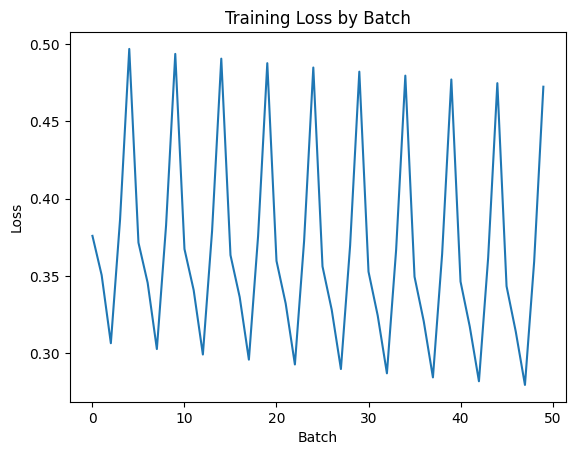

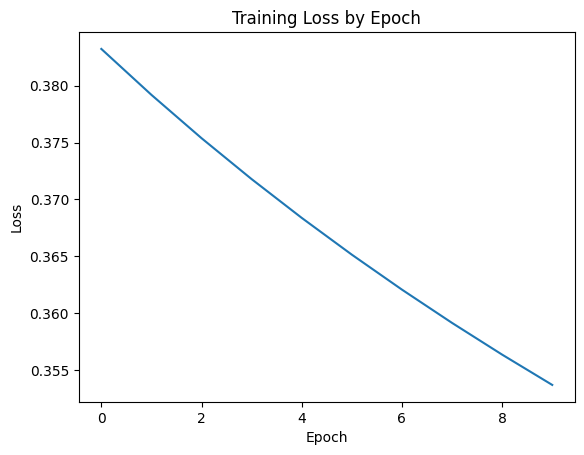

In [36]:
import matplotlib.pyplot as plt

plt.plot(historico_batch)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss by Batch')
plt.show()

plt.plot(historico)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss by Epoch')
plt.show()

En este caso, la gráfica tiene una tendencia descendente, sin embargo, existen zonas periódicas en las que la función de pérdida sube y luego vuelve a bajar. Si nos fijamos, en el último batch siempre sube un poco el valor de la pérdida.

Sin embargo, si obtenemos los valores de loss cada 100 batches (cada época) entonces si veremos que es descendente en toda la gráfica.

Para mejorar deberíamos revisar los hiperparámetros: número de épocas, batches, la funcion de activación, el número de capas... para comprobar con cuáles funciona mejor nuestro modelo.

---
❓❓❓

**EJERCICIO**: Prueba:
* reemplazar el optimizador por [otro de Keras](https://keras.io/api/optimizers/).
* Prueba a cambiar la tasa de aprendizaje y a activar el momento.

❓❓❓

In [37]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=0.005, beta_1=0.9) # Cambio a Adam

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

Epoch 0
loss at batch 0: 0.34
loss at batch 100: 9.55
loss at batch 200: 8.89
loss at batch 300: 9.22
loss at batch 400: 10.31
Epoch 1
loss at batch 0: 0.61
loss at batch 100: 0.18
loss at batch 200: 0.34
loss at batch 300: 0.15
loss at batch 400: 0.34
Epoch 2
loss at batch 0: 0.09
loss at batch 100: 0.13
loss at batch 200: 0.21
loss at batch 300: 0.14
loss at batch 400: 0.17
Epoch 3
loss at batch 0: 0.10
loss at batch 100: 0.10
loss at batch 200: 0.14
loss at batch 300: 0.12
loss at batch 400: 0.12
Epoch 4
loss at batch 0: 0.07
loss at batch 100: 0.03
loss at batch 200: 0.16
loss at batch 300: 0.11
loss at batch 400: 0.16
Epoch 5
loss at batch 0: 0.09
loss at batch 100: 0.02
loss at batch 200: 0.06
loss at batch 300: 0.06
loss at batch 400: 0.14
Epoch 6
loss at batch 0: 0.05
loss at batch 100: 0.08
loss at batch 200: 0.09
loss at batch 300: 0.14
loss at batch 400: 0.18
Epoch 7
loss at batch 0: 0.07
loss at batch 100: 0.03
loss at batch 200: 0.10
loss at batch 300: 0.02
loss at batch 4

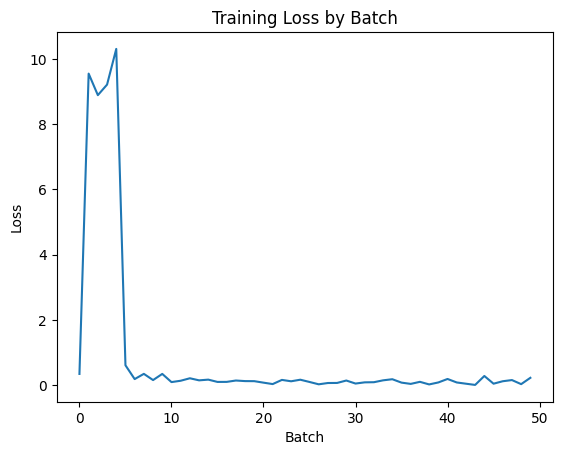

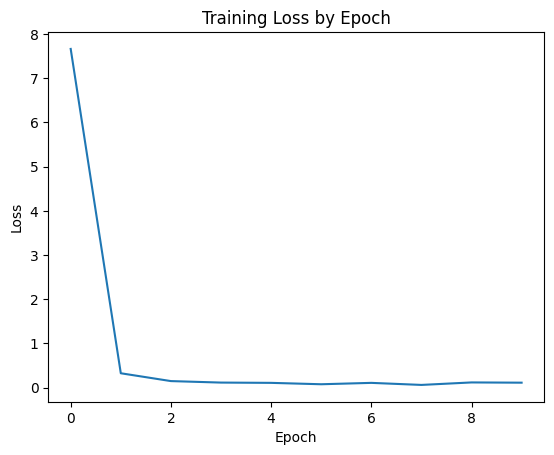

In [38]:
historico, historico_batch = fit(model, train_images, train_labels, epochs=10, batch_size=128)

plt.plot(historico_batch)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss by Batch')
plt.show()

plt.plot(historico)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss by Epoch')
plt.show()

### Evaluación del modelo

Podemos evaluar el modelo eligiendo la neurona de salida con máximo valor en la predicción del conjunto de test y comparándola con la etiqueta esperada

❓❓❓ **EJERCICIO**: Completa el código para elegir la neurona con mayor probabilidad
❓❓❓


In [ ]:
import numpy as np
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1) # CAMBIAR AQUÍ
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

❓❓❓

**EJERCICIO**:

Pon todo el código que hemos desarrollado en una única celda de manera que permita hacer varias ejecuciones.

1. Definición de clases (capa y modelo) y funciones auxiliares (batch)
1. Optimizador y actualización pesos
1. Paso de entrenamiento y función fit()
1. Cargar datos
1. Definir modelo
1. Ajustar el modelo llamando a fit()
1. Evaluar el modelo

❓❓❓

Epoch 0
loss at batch 0: 4.78
loss at batch 100: 6.69
loss at batch 200: 6.59
loss at batch 300: 6.34
loss at batch 400: 5.51
Epoch 1
loss at batch 0: 0.48
loss at batch 100: 0.19
loss at batch 200: 0.30
loss at batch 300: 0.20
loss at batch 400: 0.31
Epoch 2
loss at batch 0: 0.13
loss at batch 100: 0.06
loss at batch 200: 0.20
loss at batch 300: 0.14
loss at batch 400: 0.19
Epoch 3
loss at batch 0: 0.09
loss at batch 100: 0.06
loss at batch 200: 0.13
loss at batch 300: 0.11
loss at batch 400: 0.13
Epoch 4
loss at batch 0: 0.05
loss at batch 100: 0.09
loss at batch 200: 0.07
loss at batch 300: 0.08
loss at batch 400: 0.11
Epoch 5
loss at batch 0: 0.05
loss at batch 100: 0.03
loss at batch 200: 0.07
loss at batch 300: 0.08
loss at batch 400: 0.12
Epoch 6
loss at batch 0: 0.04
loss at batch 100: 0.04
loss at batch 200: 0.09
loss at batch 300: 0.09
loss at batch 400: 0.21
Epoch 7
loss at batch 0: 0.09
loss at batch 100: 0.06
loss at batch 200: 0.13
loss at batch 300: 0.13
loss at batch 40

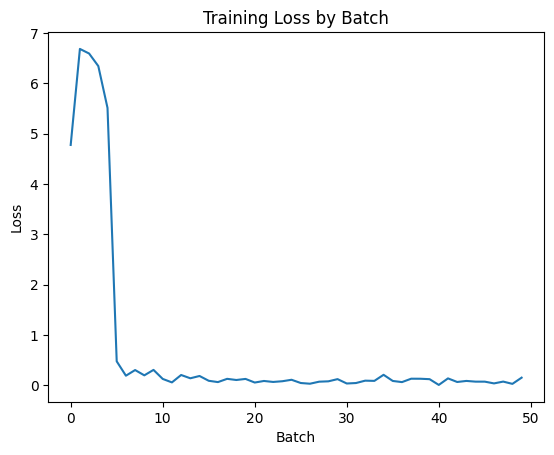

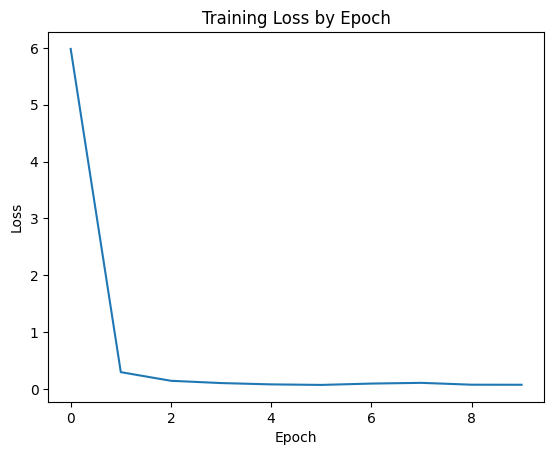

accuracy: 0.97


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist

## Capa Densa

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        # Creamos una matriz inicializada aleatoriamente de forma (input_size, output_size)

        ## Cambiamos la forma de inicialización de los pesos

        w_initial_value = tf.ones(w_shape) * 1e-1 # Inicializamos a 0.1

        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)


        self.W = tf.Variable(w_initial_value)

        # Vector inicializado con ceros de forma (output_size,)
        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs): # forward pass
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

## Capa Secuencial

class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

## Generador de Batches

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels


## Optimizador
optimizer = optimizers.Adam(learning_rate=0.005, beta_1=0.9)

# Funcion de un paso de entrenamiento.
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        # (1) llama a __call__()
        predictions = model(images_batch)
        # (2)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        # (2) media de elementos a través de las dimensiones del tensor
        average_loss = tf.reduce_mean(per_sample_losses)
    # (3) Calcula el gradiente del la función de coste/pérdida respecto a los pesos
    # del modelo de todas las capas. Los gradientes de salida son una lista
    # donde cada entrada corresponde con un peso de la lista model.weights
    gradients = tape.gradient(average_loss, model.weights)
    # (4) actualiza los pesos (a continuación)
    update_weights(gradients, model.weights)
    return average_loss

# Actualización de los pesos
def update_weights(gradients, weights):
  optimizer.apply_gradients(zip(gradients, weights))

# Funcion de entrenamiento
def fit(model, images, labels, epochs, batch_size=128):
    historico = list()
    historico_batch = list()
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        mean = 0
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")
                historico_batch.append(loss)
                mean = mean + loss
        historico.append(mean/5)
    return historico, historico_batch

## Carga de datos
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255



# Creación del modelo

model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.selu), ## Modificamos la funcion de activacion en la capa oculta. Cambiamos de relu a selu
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

## Entrenamos el modelo
historico, historico_batch = fit(model, train_images, train_labels, epochs=10, batch_size=128)

plt.plot(historico_batch)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss by Batch')
plt.show()

plt.plot(historico)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss by Epoch')
plt.show()


## Evaluar modelo
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")